# CSE-6040 Extra Credit Analysis #
### Utilizing Video Game Sales Dataset: year_genre_region.csv ###
https://www.kaggle.com/datasets/stetsondone/video-game-sales-by-genre?resource=download&select=year_genre_region.csv

by John Welch

-----------------------------------------------------
# Introduction #

The data set we'll be analyzing includes the total video game sales for different regions and genres spanning the years 1980-2020.

To give an idea of why we might anaylze something like this, let's assume we are working with a **new game developer** that wants to make a brand new video game. Let's also assume they would like to **appeal to the widest audience**, selling the most popular genre in the **most profitable regions**.

There are **3 primary objectives** to this anaylsis:
  1. **Clean the Data** (Part 1)
  2. **Anaylze the Data** (Part 2)
  3. **Provide Useful Outputs** (Intermixed in Parts 1 & 2)
    
In addition, there are **4 questions** we would like to answer:
  1. What are the top 3 game genres with the most sales?
  2. What genre sells the least?
  3. Is there a close top 4th?
  4. Is there any top 3 genre that will not sell as well in a specific region, compared to the others?



### Loading Modules & Dataset ###

As is tradition, we'll start by loading in the relevant modules and dataset. After that we'll verify that everything loaded in ok without any problems or errors.

In [1]:
# Loading Modules
from io import StringIO
from IPython.display import display, Markdown
import pandas as pd
import sqlite3 as db
import bokeh
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.palettes import brewer
output_notebook ()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [2]:
# Loading Data
df = pd.read_csv('year_genre_region.csv')
print(df.index)
print('------------------------')
print('A preview of our dataset')
print('------------------------')
display(df)

RangeIndex(start=0, stop=1950, step=1)
------------------------
A preview of our dataset
------------------------


,release_year,genre,region,sales
0,1980,Action,North America,0.32
1,1980,Fighting,North America,0.72
2,1980,Misc,North America,2.53
3,1980,Shooter,North America,6.56
4,1980,Sports,North America,0.46
...,...,...,...,...
1945,2016,Sports,Worldwide,23.53
1946,2016,Strategy,Worldwide,1.15
1947,2017,Action,Worldwide,0.01
1948,2017,Role-Playing,Worldwide,0.05


***sales are represented in millions**

In [3]:
#Checking Math & Statistics
print('------------------')
print("Math & Statistics:")
print('------------------')
df['sales'].describe()

------------------
Math & Statistics:
------------------


count    1950.000000
mean        9.042892
std        16.171737
min         0.000000
25%         0.690000
50%         2.920000
75%         9.580000
max       137.660000
Name: sales, dtype: float64

Upon first look at the data we can already see an issue with it. **That max value looks pretty high!**

---------------------------------------------------------------
### Interquartile Range (IQR) and Extreme Outliers ###

Now that we have the math and statistics for our dataset we can see that the min looks questionable and the max looks high. Let's take a look at both the min/max values and determine if either one of them are drastic enough to be considered **extreme outliers.**

#### Calculating the Interquartile Range (IQR) ####
**Q3 - Q1 = IQR**
- 9.58 - 0.69 = 8.89

#### Checking if min/max are 'extreme' outliers ####
If either of these are True, then x is considered to be an extreme outlier.

**x < Q1 - 3 * IQR**       
**x > Q3 + 3 * IQR**

*Checking the min*
- 0.00 < 0.69 - 3 * 8.89
- 0.00 < -25.98 = False

*Checking the max*
- 137.66 > 9.58 + 3 * 8.89
- 137.66 > 36.25 = True

**The max is indeed an extreme outlier.** You could probably tell just by seeing how far it is away from the mean and std. We'll look more into this a little later, just take note for now. More on the math here: https://people.richland.edu/james/lecture/m170/ch03-pos.html

### Non-Null Data Confirmation ###
The information below should show that there are 1950 rows in the dataframe, all of which are non-null. Therefore *at this point* there are no missing values that are immediately recognizeable.

In [4]:
#Checking for Null Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   release_year  1950 non-null   int64  
 1   genre         1950 non-null   object 
 2   region        1950 non-null   object 
 3   sales         1950 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 61.1+ KB


In [5]:
print('---------------------------------------------')
print("Amount of null values (NaN's) in each column:")
print('---------------------------------------------')
df.isnull().sum()

---------------------------------------------
Amount of null values (NaN's) in each column:
---------------------------------------------


release_year    0
genre           0
region          0
sales           0
dtype: int64

-------------------------------------------------------------------
# Part 1: Cleaning the Data #
Let's take a few basic looks at our data and begin to split, clean and filter out the parts we are not interested in.

In [6]:
#Value Counting the Regions Column
print('---------------------------------------------------------------------------------------------------')
print('The regions included in the dataset and their value counts. Worldwide is not comparable the others.')
print('---------------------------------------------------------------------------------------------------')
print(df.region.value_counts())

---------------------------------------------------------------------------------------------------
The regions included in the dataset and their value counts. Worldwide is not comparable the others.
---------------------------------------------------------------------------------------------------
North America     390
European Union    390
Japan             390
Other             390
Worldwide         390
Name: region, dtype: int64


### Splitting the Datasets ###
In order to get a fair view of this dataset, we'll have to split it into 2 different dataframes. One including just the worldwide region, and the other including everything but the worldwide region (we'll call the latter **"Relevant Regions"**.)

**Relevant Regions:** North America, European Union, Japan, Other.

*Naturally it's unfair to equally compare something like Japan's sales to Worldwide sales.*

In [7]:
#Dropping Worldwide from the Dataframe (creating a Relevant Regions Dataframe)
df_No_WW = df.copy()
filt = df_No_WW['region'] != 'Worldwide'
df_No_WW = df_No_WW.loc[filt]
print('----------------------------------------')
print('The Relevant Regions Dataframe (Preview)')
print('----------------------------------------')
display(df_No_WW)


#Dropping everything but Worldwide from the Dataframe (creating a Worldwide Dataframe)
df_WW = df.copy()
filt = ((df_WW['region'] != 'North America') & (df_WW['region'] != 'Japan') & (df_WW['region'] != 'Other') & 
        (df_WW['region'] != 'European Union'))
df_WW = df_WW.loc[filt]
print('--------------------------------------')
print('The Worldwide only Dataframe (Preview)')
print('--------------------------------------')
display(df_WW)

----------------------------------------
The Relevant Regions Dataframe (Preview)
----------------------------------------


,release_year,genre,region,sales
0,1980,Action,North America,0.32
1,1980,Fighting,North America,0.72
2,1980,Misc,North America,2.53
3,1980,Shooter,North America,6.56
4,1980,Sports,North America,0.46
...,...,...,...,...
1555,2016,Sports,Other,3.02
1556,2016,Strategy,Other,0.07
1557,2017,Action,Other,0.00
1558,2017,Role-Playing,Other,0.00


--------------------------------------
The Worldwide only Dataframe (Preview)
--------------------------------------


,release_year,genre,region,sales
1560,1980,Action,Worldwide,0.34
1561,1980,Fighting,Worldwide,0.77
1562,1980,Misc,Worldwide,2.71
1563,1980,Shooter,Worldwide,7.07
1564,1980,Sports,Worldwide,0.49
...,...,...,...,...
1945,2016,Sports,Worldwide,23.53
1946,2016,Strategy,Worldwide,1.15
1947,2017,Action,Worldwide,0.01
1948,2017,Role-Playing,Worldwide,0.05


-----------------------------------------------------------
### Looking at the largest 6 sales values for each dataframe ###

Below we can see the **Top 6** sales observations for each dataframe. This is not representative of the associated genres as a whole, just the **highest instances of sales**. Taking a look at this can help us decide whether or not we want to remove outliers.

In [8]:
print('--------------------------')
print('Worldwide Top 6')
print('--------------------------')
df_WW.nlargest(6, ['sales'])

--------------------------
Worldwide Top 6
--------------------------


,release_year,genre,region,sales
1851,2009,Action,Worldwide,137.66
1861,2009,Sports,Worldwide,137.33
1825,2006,Sports,Worldwide,135.83
1839,2008,Action,Worldwide,135.01
1899,2013,Action,Worldwide,122.57
1887,2012,Action,Worldwide,119.10


In [9]:
print('--------------------------')
print('Relevant Regions Top 6')
print('--------------------------')
df_No_WW.nlargest(6, ['sales'])

--------------------------
Relevant Regions Top 6
--------------------------


,release_year,genre,region,sales
265,2006,Sports,North America,72.78
279,2008,Action,North America,72.02
291,2009,Action,North America,71.08
301,2009,Sports,North America,70.85
303,2010,Action,North America,59.72
267,2007,Action,North America,58.43


----------------------------------------
In both **Top 6** results above, the top 4 or 5 seem to be very close to each other (and close to the max). This tells us two things:
1. Removing the worldwide region won't mitigate this fact (adds credibility to the potential outliers).
2. It's not one single point miles above the rest. 

Remember earlier we found the max for the entire dataframe was **137.66**. Below are the math and statistics for the Relevant Regions dataframe, showing their respective max of **72.78**.

----------------------------------------

In [10]:
print('---------------------------------------')
print("Math & Statistics for Relevant Regions:")
print('---------------------------------------')
df_No_WW['sales'].describe()

---------------------------------------
Math & Statistics for Relevant Regions:
---------------------------------------


count    1560.000000
mean        5.650462
std         9.249308
min         0.000000
25%         0.460000
50%         2.130000
75%         6.312500
max        72.780000
Name: sales, dtype: float64

------------------------------------------------------------------
### Looking at the smallest 6 sales values for each dataframe ###
Below we can see the **Bottom 6** sales observations for each dataframe. **This is important** when deciding whether or not to consider 0.0 sales observations as bad data or not.

In [11]:
print('--------------------------')
print('Worldwide Bottom 6')
print('--------------------------')
df_WW.nsmallest(6, ['sales'])

--------------------------
Worldwide Bottom 6
--------------------------


,release_year,genre,region,sales
1940,2016,Puzzle,Worldwide,0.01
1947,2017,Action,Worldwide,0.01
1598,1985,Simulation,Worldwide,0.03
1619,1988,Simulation,Worldwide,0.03
1948,2017,Role-Playing,Worldwide,0.05
1660,1993,Adventure,Worldwide,0.07


In [12]:
print('--------------------------')
print('Relevant Regions Bottom 6')
print('--------------------------')
df_No_WW.nsmallest(6, ['sales'])

--------------------------
Relevant Regions Bottom 6
--------------------------


,release_year,genre,region,sales
27,1984,Misc,North America,0.0
28,1984,Platform,North America,0.0
34,1985,Fighting,North America,0.0
38,1985,Simulation,North America,0.0
59,1988,Simulation,North America,0.0
62,1989,Misc,North America,0.0


In both **Bottom 6** results above, we see some pretty low sales values (especially for the Relevant Regions dataframe.)

In [13]:
#While we're at it, let's count how many 0.0 results are in our dataframes as well.
count = (df_No_WW['sales'] == 0.0).sum()
print('Count of observations with 0.0 sales in the Worldwide dataframe: ', 0) #see above bottom 6
print('Count of observations with 0.0 sales in the Relevant Regions dataframe: ', count)

Count of observations with 0.0 sales in the Worldwide dataframe:  0
Count of observations with 0.0 sales in the Relevant Regions dataframe:  108


### Are these 0.0 values above accurate? ###

We are often given incorrect or missing data. Sometimes this is hard to tell, so lets use the year 2017 and some outside sources as an example. 

In [14]:
#Using 2017 as an example
filt2017 = df['release_year'] == 2017
print('-------------------------------------')
print('All records for the release_year 2017')
print('-------------------------------------')

print(df.loc[filt2017])

-------------------------------------
All records for the release_year 2017
-------------------------------------
      release_year         genre          region  sales
387           2017        Action   North America   0.00
388           2017  Role-Playing   North America   0.00
777           2017        Action  European Union   0.00
778           2017  Role-Playing  European Union   0.00
1167          2017        Action           Japan   0.01
1168          2017  Role-Playing           Japan   0.05
1557          2017        Action           Other   0.00
1558          2017  Role-Playing           Other   0.00
1947          2017        Action       Worldwide   0.01
1948          2017  Role-Playing       Worldwide   0.05


---------------------------------------
The above sales results are suspiciously low.
-----------------------------------------

To quote an outside source:

**"2017 has been widely hailed as the best year ever for video games. And perhaps rightfully so.**

*Within those twelve months we saw the release of Legend of Zelda: Breath of the Wild, Resident Evil 7, Nioh, Persona 5, Horizon: Zero Dawn, Neir: Automata, Super Mario Odyssey, Destiny 2, PlayerUnknown’s Battlegrounds, Cuphead, Splatoon 2, Sonic Mania, Divinity: Original Sin 2, Metroid: Samus Returns, Hellblade: Senua’s Sacrifice, Injustice 2…"*

https://levelupentertainment.com/blog/2018/1/22/2017-vs-1998-battle-for-the-best-year-ever

For reference, just one of the many games above **"Legend of Zelda: Breath of the Wild"** sold almost 5 million units in 2017.
Nintendo identifies this game as an Action-Adventure game. The **Action** genre should have more than **0.0 sales.**

https://www.ign.com/articles/2017/10/30/zelda-breath-of-the-wild-sales-pass-47-million-on-switch

Furthermore, **where are the rest of the genres for the year 2017?** We only see Action & Role-Playing.
In the next section below we'll see a list of all the genres included in this dataset that should be present in the year 2017.


--------------------------------------------
### The "Big 12" Genres ###

#### Below we will see how many observations we have per 'genre'. ####

In [15]:
print('There are 12 genres included in the data set.')
print('---------------------------------------------')
print(df.genre.value_counts())
print('-----------------------------------------------------------')
print('Note the low number of observations for the Strategy genre.')

There are 12 genres included in the data set.
---------------------------------------------
Action          190
Sports          185
Shooter         180
Platform        180
Puzzle          170
Racing          160
Role-Playing    160
Misc            155
Simulation      155
Fighting        145
Adventure       140
Strategy        130
Name: genre, dtype: int64
-----------------------------------------------------------
Note the low number of observations for the Strategy genre.


The suspiciously low sales numbers and lack of genres being observed in 2017 is an obvious sign of **both bad and missing data**. We should also check the amount of observations for each other year in the data set, as 2017 might not be the only year with low observations.

#### Below we will see how many observations we have per 'release_year'. ####

-------------------------------
Number of Observations per Year
-------------------------------


,release_year,observations
0,1980,25
1,1981,35
2,1982,35
3,1983,35
4,1984,35
5,1985,35
6,1986,30
7,1987,35
8,1988,40
9,1989,35


Notice we are completely missing all data for years 2018 and 2019
The number of release_year entries:  39
The number of release_year entries if 2018 & 2019 are added:  41
If we are to assume that only release_years with 60 observations are complete...
then there are a lot of incomplete release_years!
Amount of observations in our dataset: 1950
Amount of observations in a complete dataset: 2460
------------------------------------------------------------
Video Game Observations by Year, excluding years 2018 & 2019
------------------------------------------------------------


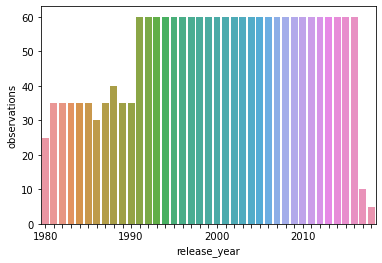

In [16]:
#Counting Observations Per release_year
records = df.release_year.value_counts().sort_index(axis=0)
records = records.rename_axis('release_year').reset_index(name='observations')
print('-------------------------------')
print('Number of Observations per Year')
print('-------------------------------')
display(records)

#Creating a copy of the dataframe for future use
df1 = df.copy()

#Creating the Bar Chart
barplot = sns.barplot(data=records, x='release_year', y='observations')
for ind, label in enumerate(barplot.get_xticklabels()):
    if ind % 10 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
print("Notice we are completely missing all data for years 2018 and 2019")
print("The number of release_year entries: ", len(records))
print("The number of release_year entries if 2018 & 2019 are added: ", (len(records)+2))
print('If we are to assume that only release_years with 60 observations are complete...')
print('then there are a lot of incomplete release_years!')
print("Amount of observations in our dataset: 1950")
print("Amount of observations in a complete dataset: 2460")
print('------------------------------------------------------------')
print("Video Game Observations by Year, excluding years 2018 & 2019")
print('------------------------------------------------------------')

### Bivariate Distribution - Visual Aid ###

Text(0.5, 0.98, 'Video Game Sales by Year')

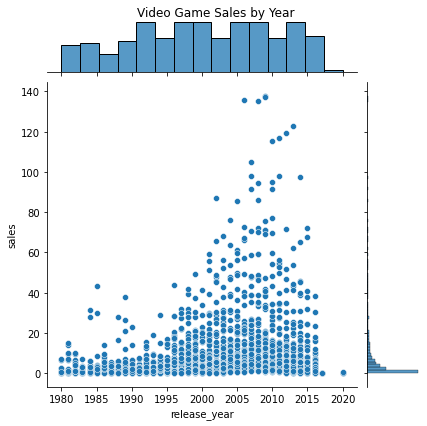

In [17]:
df2 = pd.DataFrame(df1, columns=["release_year", "sales"])
vgsp = sns.jointplot(x="release_year", y="sales", data=df2)
vgsp.fig.subplots_adjust(top=0.95)
vgsp.fig.suptitle('Video Game Sales by Year')

### Scatterplot - Visual Aid ###

In [18]:
p = figure(title = "Video Game Sales by Year")
p.circle('release_year','sales',source=df1,fill_alpha=0.2, size=10)
show(p)

### Missing Data: 2018 & 2019 ###
With the help of the charts above, we can clearly see we are missing *all* observations for the years **2018** & **2019**, in addition to having barely any observations for the years **2017** & **2020**. Furthermore, many of the years prior to 1991 seem to be missing observations. Therefore it might be reasonable to conclude that we only have (1950/2460) **79% observed data**, while the remaining **21% is missing data**. Again, this is assuming that release_years without 60 observations are considered incomplete. However, **this might not the case.**

#### All "Big 12" genres might not have been well documented before 1990, purposely left out, absorbed into other genres, or perhaps observing only the top 10 genres was the norm at the time.  ####

In the 3 figures below, you will notice the following:

- **Figure 1A: 1980-1985** Observations are missing the **Role-Playing & Strategy** Genres.
- **Figure 2A: 1980-1990** Observations are missing the **Strategy** Genres.
- **Figure 3A: 1980-1995** Observations finally include **all 12** Genres.

The Role-Playing Genre doesn't make an appearance in this data set until the years 1985-1990.

The Strategy Genre doesn't make an appearance in this data set until the years 1990-1995.

*Figures 1A, 2A, & 3A all start at year 1980 and incrementally add 5 years to the span. Sales are in yearly averages.*

------------------------------------
FIGURE 1A: 1980-1985, 10 of 12 Genres
------------------------------------


Text(0.5, 1.0, 'Figure 1A: 1980-1985')

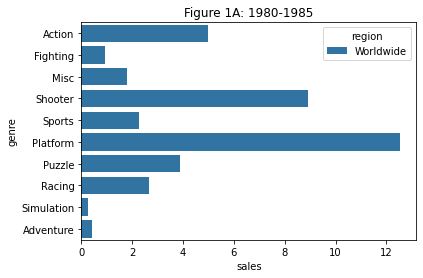

In [19]:
print('------------------------------------')
print('FIGURE 1A: 1980-1985, 10 of 12 Genres')
print('------------------------------------')
df_WW_1985 = df_WW.copy()
filt = (df_WW_1985['region'] == 'Worldwide') & (df_WW_1985['release_year'] <= 1985) 
df_WW_1985 = df_WW_1985.loc[filt]
sns.barplot(x="sales", y="genre", hue="region", ci=None, data=df_WW_1985).set_title('Figure 1A: 1980-1985')

**Notice the Role-Playing and Strategy genres are absent in Figure 1A.**

------------------------------------
FIGURE 2A: 1980-1990, 11 of 12 Genres
------------------------------------


Text(0.5, 1.0, 'Figure 2A: 1980-1990')

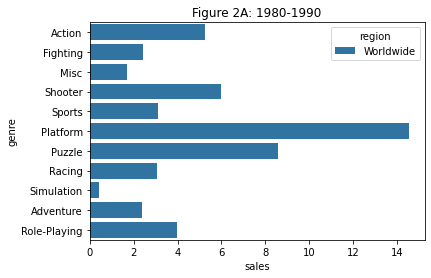

In [20]:
print('------------------------------------')
print('FIGURE 2A: 1980-1990, 11 of 12 Genres')
print('------------------------------------')
df_WW_1990 = df_WW.copy()
filt = (df_WW_1990['region'] == 'Worldwide') & (df_WW_1990['release_year'] <= 1990) 
df_WW_1990 = df_WW_1990.loc[filt]


sns.barplot(x="sales", y="genre", hue="region", ci=None, data=df_WW_1990).set_title('Figure 2A: 1980-1990')

**Notice the Role-Playing genre is now being observed but the Strategy genre is still absent in Figure 2A.**

------------------------------------
FIGURE 3A: 1980-1995, 12 of 12 Genres
------------------------------------


Text(0.5, 1.0, 'Figure 3A: 1980-1995')

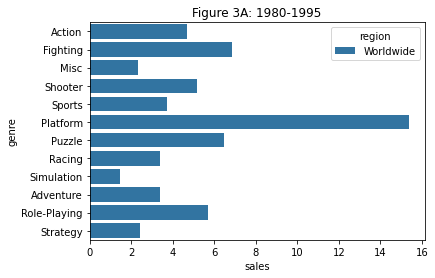

In [21]:
print('------------------------------------')
print('FIGURE 3A: 1980-1995, 12 of 12 Genres')
print('------------------------------------')
df_WW_1995 = df_WW.copy()
filt = (df_WW_1995['region'] == 'Worldwide') & (df_WW_1995['release_year'] <= 1995) 
df_WW_1995 = df_WW_1995.loc[filt]


sns.barplot(x="sales", y="genre", hue="region", ci=None, data=df_WW_1995).set_title('Figure 3A: 1980-1995')

**Notice the Strategy genre and now all Big 12 genres are being observed in Figure 3A.**

Interesting to note that during this whole time, the Platform genre dominated the video game industry.
Another interesting side note is that we still have equal observations by regions during this time (seen below), despite missing the proposed "complete 60" observations each year should have. This means that no particular region is at fault for missing data during this time.

In [22]:
#Checking region observations between 1980 - 1995.
filtReg = (df['release_year'] >= 1980) & (df['release_year'] <= 1995)
dfReg = df.loc[filtReg]
print('--------------------------------------------')
print('Number of Observations per Region: 1980-1995')
print('--------------------------------------------')
dfReg.region.value_counts()

--------------------------------------------
Number of Observations per Region: 1980-1995
--------------------------------------------


North America     135
European Union    135
Japan             135
Other             135
Worldwide         135
Name: region, dtype: int64

## Cleaning the Data: Imputation & Removal ##

There are certainly some issues with our data. Here are some of the things we have found out thus far:

- We have some **extreme outliers** on the high end (the max values).
- There are a lot of **0.0 values** (108 of them) in our data set. We can research some of them (such as the year 2017) and conclude they are bad data. However, researching every instance of 0.0 is tedious and inefficient.
- Data from **2017-2020** is either sparse or completely absent.
- A couple genres **(Role-Playing & Strategy)** are completely absent until 5 or 10 years into the dataset.

With the information we've gathered, we can now **decide whether or not to take action.**

#### Should we remove outliers? ####
Although the outliers are extreme, it's not one single point guilty of skewing the data. This is the perfect example of a question we would want to ask the people we are analyzing this data for (in this scenario, the game developers.) Do they want us to be generous or conservative with outliers? For simplicity, we will be conservative and keep the outliers in our dataset.

#### Should we remove all 0.0 values from our dataset? ####
After using 2017 as an example, we can definitely see how misplaced 0.0 sales values can gravely affect the credibility of our data set. On the other hand, we cannot just assume every 0.0 is a bad or missing value. The majority of our 0.0's could be completely legitimate observations and removing all of them might be more harmful than good. We will be conservative on this issue as well.

#### Should we remove the years 2017-2020 from our dataset? ####
Yes. It is abundantly clear that there is little to no relevant data among these years in our dataset. There is no need to be conservative here.

#### Should we impute values for the missing genres? ####
This one is tricky. Although we could impute the mean or median sales for the Roleplaying & Strategy genres for the earlier years, it might do more harm than good. (For example, we may incorrectly account for inflation over the years.) Furthermore, while I cannot answer this question, there seems to be a clear intention on leaving the two genres unobserved. Perhaps only the top 10 were observed at this time and they didn't make the cut, or perhaps it was a common practice in the 1980's to absorb certain genres together (like merging Platform & Role-Playing genres together.) It's even possible that the data was just lost all together. Either way, most gamers would recognize Role-Playing & Strategy games to be some of the most popular genres over the years so their absence is strange. For these reasons, we will refrain from ill-informed imputation.

Below we will take action and move forward with removing the years 2017-2020 from our dataset. 

In [23]:
#Removing 2017-2020 data from our original dataframe
filtYears0 = df1['release_year'] <= 2016
df1 = df1.loc[filtYears0]

#Removing 2017-2020 data from our Relevant Regions dataframe
filtYears1 = df_No_WW['release_year'] <= 2016
df_No_WW = df_No_WW.loc[filtYears1]

#Removing 2017-2020 data from our Worldwide dataframe
filtYears2 = df_WW['release_year'] <= 2016
df_WW = df_WW.loc[filtYears2]

print('Data Cleaning Complete!')

Data Cleaning Complete!


-------------------------------------------------
## Part 2: Analyzing the Data ##

Here we are going to start taking a look at our data with some simple SQL queries and visualize some results. We will first show the original dataset, then utilize Relevant Regions dataframe for a better look.

In [24]:
#Setting up SQL Connection
conn = db.connect('df1')
c = conn.cursor()
c.execute("DROP TABLE IF EXISTS Game_SalesWW")
c.execute("CREATE TABLE Game_SalesWW (sales INTEGER, genre TEXT)")
df1.to_sql('Game_SalesWW', conn, if_exists='replace', index=False)
pd.read_sql('select * from Game_SalesWW', conn)
conn.commit()

---------------------
Total Sales by Region
---------------------


,Region,Total Sales
0,Worldwide,8818.57
1,North America,4341.42
2,European Union,2399.68
3,Japan,1290.64
4,Other,782.63


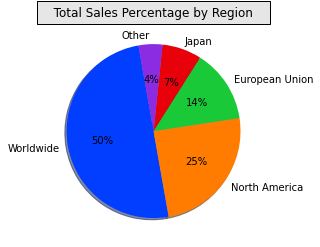

In [25]:
#Total Sales by Region Query
query = c.execute('''
        SELECT 
            DISTINCT region, SUM(sales)
        FROM 
            Game_SalesWW
        GROUP BY 
            region
        ORDER BY
            sum(sales) DESC
        ''')

Reg_Sum_df2 = pd.DataFrame(c.fetchall(), columns = ['Region', 'Total Sales'])
print('---------------------')
print('Total Sales by Region')
print('---------------------')
display(Reg_Sum_df2)


#Total Sales Pie Chart Data
region_totals = Reg_Sum_df2.groupby('Region').sum()
data = region_totals['Total Sales'].sort_values(ascending=False)
labels = Reg_Sum_df2['Region'].unique()
colors = sns.color_palette('bright')[0:5]

#Create Pie Chart
plt.pie(data, labels = labels, colors = colors, shadow=True, startangle=100, autopct='%.0f%%')
plt.title("   Total Sales Percentage by Region   ", bbox={'facecolor':'0.9', 'pad':5})
plt.show()

As you can see, leaving in the Worldwide region is redundant since it's just an accumulation of all the other regions.

Now we'll proceed with our Relevant Regions dataframe.

---------------------
Total Sales by Region
---------------------


,Region,Total Sales
0,North America,4341.42
1,European Union,2399.68
2,Japan,1290.64
3,Other,782.63


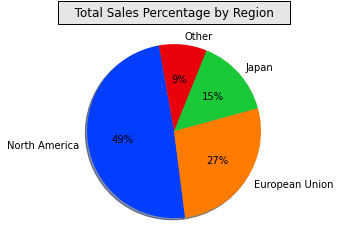

Text(0.5, 1.0, 'Total Sales by Region')

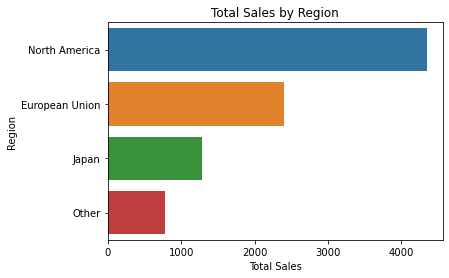

In [26]:
c.execute("DROP TABLE IF EXISTS Game_Sales")
c.execute("CREATE TABLE Game_Sales (sales INTEGER, genre TEXT)")
df_No_WW.to_sql('Game_Sales', conn, if_exists='replace', index=False)
pd.read_sql('select * from Game_Sales', conn)
conn.commit()

#Total Sales by Region Query
query = c.execute('''
        SELECT 
            DISTINCT region, SUM(sales)
        FROM 
            Game_Sales
        GROUP BY 
            region
        ORDER BY
            sum(sales) DESC
        ''')

Reg_Sum_df = pd.DataFrame(c.fetchall(), columns = ['Region', 'Total Sales'])
print('---------------------')
print('Total Sales by Region')
print('---------------------')
display(Reg_Sum_df)

#Total Sales Pie Chart Data
region_totals = Reg_Sum_df.groupby('Region').sum()
data = region_totals['Total Sales'].sort_values(ascending=False)
labels = Reg_Sum_df['Region'].unique()
colors = sns.color_palette('bright')[0:4]
#Create Pie Chart
plt.pie(data, labels = labels, colors = colors, shadow=True, startangle=100, autopct='%.0f%%')
plt.title("   Total Sales Percentage by Region   ", bbox={'facecolor':'0.9', 'pad':5})
plt.show()
#Create Bar Chart
sns.barplot(x="Total Sales", y="Region", data=Reg_Sum_df).set_title('Total Sales by Region')

## North America Dominates ##
According to this dataset, North America rules the video game industry, maintaining almost 50% of all sales among all regions. The European Union comes in 2nd, while Japan a not so distant 3rd. Then there's the 'Other' region. Let's break down the regions for a moment.

- North America: United States, Canada, Mexico, etc.
- European Union: Germany, France, Poland, etc.
- Japan: Just Japan.
- Other: I would assume smaller countries not represented by the other regions.

**Just Japan** is an interesting choice here. Those that prepared this dataset must have felt that over the years, Japan was relevant enough to be its own region. This could very well have been the case in the 1980's and 1990's.

Furthermore, **where's China?** It can't possibly be in the small 9% category, especially since it's often surpassing USA in video game sales and revenue: https://www.weforum.org/agenda/2021/08/which-countries-have-the-largest-video-gaming-markets.

### No Dataset Is Perfect ###

This is just something we want to keep in mind. While you could blame the dataset itself, there's always outside factors. Laws, censorship, and market data that isn't allowed to be shared can contribute to the lack of obtainable data.

With the regions themselves analyzed, let's go ahead and take a look at the average yearly sales for each region. Then we'll get into answering some of our 4 main questions.

In [27]:
print('------------------------------')
print('Average Yearly Sales by Region')
print('------------------------------')

#Collecting the Average Yearly Sales for each Region
query = c.execute('''
        SELECT 
            DISTINCT region, ROUND(AVG(sales),2)
        FROM 
            Game_Sales
        GROUP BY 
            region
        ORDER BY
            SUM(sales) DESC
        ''')

Reg_Avg_df = pd.DataFrame(c.fetchall(), columns = ['Region', 'Average Sales'])
display(Reg_Avg_df)

#Storing the Averages into a Dictionary
query = c.execute('''
        SELECT 
            DISTINCT region, ROUND(AVG(sales),2)
        FROM 
            Game_Sales
        GROUP BY 
            region
        ORDER BY
            SUM(sales) DESC
        ''')

data = c.fetchall() 
AVG_Sales_Dict = {}
for d in data:
    AVG_Sales_Dict[d[0]] = d[1]
print('--------------')
print('Storing averages into dictionary...')    
print(AVG_Sales_Dict)

------------------------------
Average Yearly Sales by Region
------------------------------


,Region,Average Sales
0,North America,11.22
1,European Union,6.20
2,Japan,3.33
3,Other,2.02


--------------
Storing averages into dictionary...
{'North America': 11.22, 'European Union': 6.2, 'Japan': 3.33, 'Other': 2.02}


-------------------------------------------------------
We can also store these averages into a dictionary to use for imputation. While we already decided *not to imputate* in the previous section, we can always build dictionaries like this (per genre) in case we *or* the game developers change their minds.

Now to answer some questions.

------------------------------------------------------------------
## Question 1: What are the Top 3 game genres with the most sales from 1980-2020? ##
Let's do a little data organization with our Relevant Regions dataframe to find this answer.

In [28]:
TopGames = df_No_WW.groupby('genre')['sales'].sum().reset_index()
TopGames = TopGames.sort_values('sales', ascending=False)
TopGames = TopGames.reset_index(drop=True)
print('-----------------------')
print('Genres Ordered by Sales')
print('-----------------------')
TopGames

-----------------------
Genres Ordered by Sales
-----------------------


,genre,sales
0,Action,1716.52
1,Sports,1309.67
2,Shooter,1041.36
3,Role-Playing,931.08
4,Platform,825.55
5,Misc,790.29
6,Racing,723.49
7,Fighting,442.66
8,Simulation,387.96
9,Puzzle,239.89


In [29]:
print('-----------------')
print('Top 3 Game Genres')
print('-----------------')
TopGames.head(3)

-----------------
Top 3 Game Genres
-----------------


,genre,sales
0,Action,1716.52
1,Sports,1309.67
2,Shooter,1041.36


---------------------------------------
### Top 3: Action, Sports, & Shooter ###
The above **Top 3** genres give us some insight on what game type we should recommend to our game developer. We should encourage our developers to choose from one of these 3 genres, **highly recommending the Action genre.** The Action genre has **31%** more sales than the 2nd closest genre Sports. ((1716.52/1309.67) - 1) = 0.31

-----------------------------------------------------------------
## Question 2: What genre sells the least? ##
As the dataset and the chart below suggest, the **'Strategy'** genre sells the least. Keep in mind however that the Strategy genre was a absent in this data set from until around the 1990's. That's about **10 years worth of missing sales data.** With that in mind, it's safe to say that our game developers should probably stray away from the **Puzzle, Adventure, and Strategy** genres if they want to target the greatest audience.

Text(0.5, 1.0, 'Total Sales by Genre: 1980-2016')

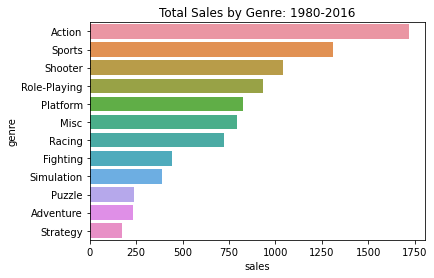

In [30]:
sns.barplot(x="sales", y="genre", data=TopGames).set_title('Total Sales by Genre: 1980-2016')

## Question 3: Is there a close Top Number 4? ##
The closest number 4 genre is the Role-Playing genre, as shown above. It's really not that far behind the Shooter genre and is something for our game developers to consider. Let's dig a little deeper and find some more information about these top 4 genres, analyzing their sales over time.

In [31]:
#Putting together a Top 4 Dataframe
filtTop4 = ((df_WW['genre'] == 'Action') | (df_WW['genre'] == 'Sports') | (df_WW['genre'] == 'Shooter')
            | (df_WW['genre'] == 'Role-Playing'))
Top4 = df_WW.loc[filtTop4]

Text(0.5, 1.0, 'Top 4 Genre Sales 1980-2016')

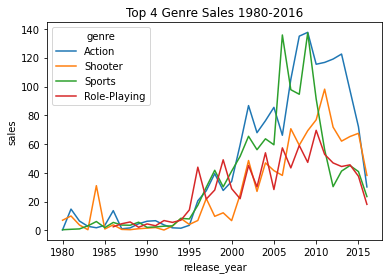

In [32]:
sns.lineplot(x="release_year", y='sales', hue='genre', ci=None, data=Top4).set_title('Top 4 Genre Sales 1980-2016')

The chart above shows the **1980-2016 sales data** for the **Top 4 genres** (remember we removed bad 2017-2020 data.)

For clarity sake, let's also look at each genre individually.

Text(0.5, 1.0, 'Action Genre Sales 1980-2016')

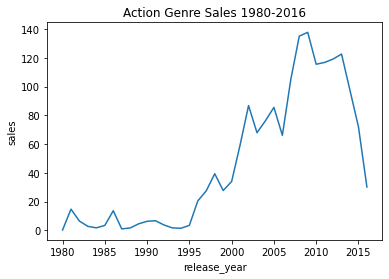

In [33]:
#Splitting Genres into individual lineplots
filtTop4A = (df_WW['genre'] == 'Action')
Top4A = df_WW.loc[filtTop4A]

filtTop4SP = (df_WW['genre'] == 'Sports')
Top4SP = df_WW.loc[filtTop4SP]

filtTop4SH = (df_WW['genre'] == 'Shooter')
Top4SH = df_WW.loc[filtTop4SH]

filtTop4RP = (df_WW['genre'] == 'Role-Playing')
Top4RP = df_WW.loc[filtTop4RP]

sns.lineplot(x="release_year", y='sales', data=Top4A).set_title('Action Genre Sales 1980-2016')

Text(0.5, 1.0, 'Sports Genre Sales 1980-2016')

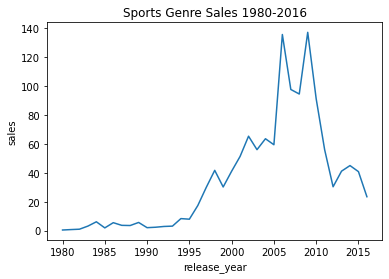

In [34]:
sns.lineplot(x="release_year", y='sales', data=Top4SP).set_title('Sports Genre Sales 1980-2016')

Text(0.5, 1.0, 'Shooter Genre Sales 1980-2016')

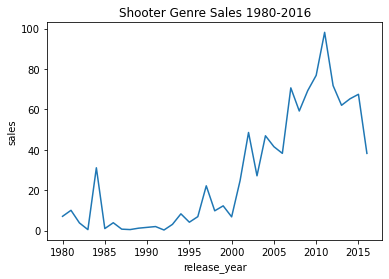

In [35]:
sns.lineplot(x="release_year", y='sales', data=Top4SH).set_title('Shooter Genre Sales 1980-2016')

Text(0.5, 1.0, 'Role-Playing Genre Sales 1980-2016')

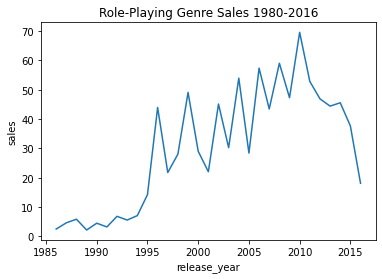

In [36]:
sns.lineplot(x="release_year", y='sales', data=Top4RP).set_title('Role-Playing Genre Sales 1980-2016')

### Role-Playing Genre ###

The Roleplaying Genre has a pretty wild history of sales! It seems to indicate that every few years a **strong video game release** happens. Perhaps this can be related to one or two immensely popular game titles, like the famous **Final Fantasy** game series, releasing a new title to their collection every few years. The **Elder Scrolls** series might also be an accomplice to this, as both are well known to the gaming industry as the most popular Role-Playing game franchises.

More on that here: https://www.thetoptens.com/franchises/rpg-series/

At any rate, if our game developers decide to make a Role-Playing video game, we want to advise them to **carefully plan their release date** around these other two monstrous titles!

### Dropping Sales for all Genres? ###

Interestingly enough, our dataset seems to suggest **sales are dropping** for all genres. This could be due to technological factors like pirating video games or the ability to share games online with others (Steam Family Sharing). Economical factors like inflation could also contribute to this. Unfortunately, since we did prove earlier that the sales data for 2017 was incorrect, it might simply suggest that the **most recent years data might be inaccurate.**

Text(0.5, 1.0, 'Top 4 Avg. Yearly Sales by Region: 1980-2016')

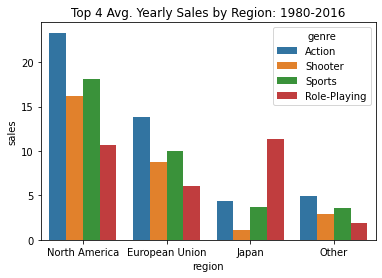

In [37]:
#Putting together a Top 4 Relevant Region Dataframe
filtTop4RR = ((df_No_WW['genre'] == 'Action') | (df_No_WW['genre'] == 'Sports') | (df_No_WW['genre'] == 'Shooter')
            | (df_No_WW['genre'] == 'Role-Playing'))
Top4RR = df_No_WW.loc[filtTop4RR]
sns.barplot(x="region", y="sales", hue="genre", ci=None,data=Top4RR).set_title('Top 4 Avg. Yearly Sales by Region: 1980-2016')

### Top 4 Genre Sales by Region ###
For the most part the **Top 3: Action, Sports, and Shooter** game genres perform consistently across all regions (in regards to their respective sales hierarchy: Action > Sports > Shooter.) On the other hand, we do notice something interesting with Japan, so let's take a closer look at Japan alone.

Text(0.5, 1.0, 'Top 4 Avg. Yearly Sales by Genre in Japan: 1980-2016')

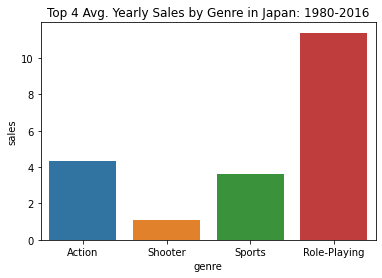

In [38]:
filtTop4J = (Top4RR['region'] == 'Japan')
Top4J = Top4RR.loc[filtTop4J]
sns.barplot(x="genre", y="sales", ci=None, data=Top4J).set_title('Top 4 Avg. Yearly Sales by Genre in Japan: 1980-2016')

### Role-Playing #1 in Japan ###

Wow, **look at those Role-Playing game sales!** Not only does this genre jump into the Top 3 for Japan, it shoots straight to the **Top #1!**

What's the deal with **Shooter sales being so low in Japan?** Well, looking into outside sources, it appears that Shooter (FPS) games were made to appeal to a mostly American audience. As our data and below sources back up, American made Shooter games have never sold well in Japan. Furthermore, Japan has a proud history of popular Role-Playing (RPG) game titles, like the **Dragon Quest** and **Final Fantasy** franchises. To quote an outside source:

**"FPS games have become more popular; however, most Japanese people are resistant to FPS games," said Kouji Aizawa, editor in chief of Famitsu PS, a popular gaming magazine in Japan .  "A lot of people [still] resent the idea of shooting people in games."* 

*https://www.nbcnews.com/id/wbna4780423

More on this topic here: https://www.japantimes.co.jp/life/2012/05/02/digital/japans-gamers-are-starting-to-shoot-em-up/


## Question 4: Is there any Top 3 Genre that won't sell well in one region compared to the rest? ##
As we just found out above, Shooters will not sell well in Japan. Aside from that instance, there should be no other issues like this among the Top 4.

Text(0.5, 1.0, 'Avg. Yearly Sales: Role-Playing vs Shooter')

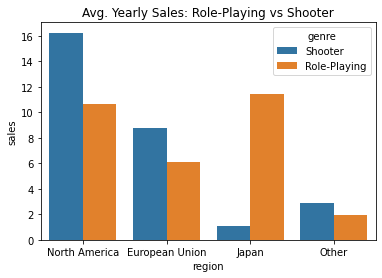

In [39]:
RvsS_filt = (df_No_WW['genre'] == 'Shooter') | (df1['genre'] == 'Role-Playing')
RvsS_df = df_No_WW.loc[RvsS_filt]
sns.barplot(x="region", y="sales", hue="genre", ci=None, data=RvsS_df).set_title('Avg. Yearly Sales: Role-Playing vs Shooter')

There really is a dramatic difference in the amount of sales between Shooter games and Role-Playing games in Japan. Let's take a better look at the sales numbers so we can better put it into perspective.

In [40]:
#Filtering the data and calculating sales...
filtJ = ((df1['region'] == 'Japan') & ((df1['genre'] == 'Shooter') | (df1['genre'] == 'Role-Playing')))
JSales = df1.loc[filtJ]
JSales = JSales.groupby('genre')['sales'].sum().reset_index()
JSales = JSales.sort_values('sales', ascending=False)
print('---------------------------------------------------------------')
print('Total Sales in Japan by Genre: Roleplaying vs Shooter 1980-2016')
print('---------------------------------------------------------------')
JSales

---------------------------------------------------------------
Total Sales in Japan by Genre: Roleplaying vs Shooter 1980-2016
---------------------------------------------------------------


,genre,sales
0,Role-Playing,353.39
1,Shooter,38.68


Over the past 40 years, our dataset suggests that in Japan the Role-Playing game genre earned **$314.71 million dollars more** than the Shooter genre did in Japan. (353.39 - 38.68 = 314.71)

To get a little better idea of how those numbers look in the big picture, let's take a glance at all worldwide video game sales over time. Remember, sales numbers are in millions.

----------------------------
Sales by Year for All Genres
----------------------------


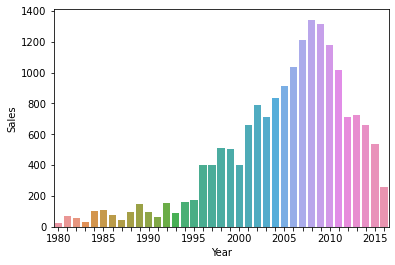

In [41]:
c.execute("DROP TABLE IF EXISTS Worldwide_Sales")
c.execute("CREATE TABLE Worldwide_Sales (sales INTEGER, genre TEXT)")
df1.to_sql('Worldwide_Sales', conn, if_exists='replace', index=False)
pd.read_sql('select * from Worldwide_Sales', conn)
conn.commit()

#Total Sales by Region Query
query = c.execute('''
        SELECT 
            DISTINCT release_year, SUM(sales)
        FROM 
            Worldwide_Sales
        GROUP BY 
            release_year
        ORDER BY
            sum(sales) DESC
        ''')

WW_Sum = pd.DataFrame(c.fetchall(), columns = ['Year', 'Sales'])

print('----------------------------')
print('Sales by Year for All Genres')
print('----------------------------')
barplot = sns.barplot(data=WW_Sum, x='Year', y='Sales', ci=None)
for ind, label in enumerate(barplot.get_xticklabels()):
    if ind % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

It looks like the **best year** for the gaming industry was **2008**, followed by a close **2009**. Here they both appear to be breaching past **$1300 million**. The **worst year** for the gaming industry is the first recorded one at **1980**, which is likely the case for many industries.

------------------------------------------------------------------
## Insights ##
Here are some of the insights we've gathered with our analysis, which we will share with our game developers.

- **The Top 3 video game genres are Action, Sports, and Shooter**, in that order. There is a regional exception with Japan however, as the Top 3 game genres in that region are Role-Playing, Action, and Sports. The Shooter genre does not sell well in Japan.

- **The Role-Playing genre is the 4th most popular**, but 1st most popular in Japan. It's not far behind the Shooter genre, so depending on your target market it's worthy of mention.

- **Action is the most popular genre** that surpasses the second most popular genre (Sports) by **31%**. *The Action genre is highly recommended.*

- **The least most popular game genres are Strategy, Adventure, and Puzzle.** It's worth mentioning that 10 years worth of Strategy genre data is missing and likely contributes to the genres low perceived popularity.

- **Platform Games dominated** the video game industry between **1980-1995.** This is likely due to the popularity of arcade machines during that time.

- **Action** games had their best years in **2008, 2009, 2012, and 2013.** **Sports** games had their best years in **2006 and 2009.** These are the 6 highest instances of sales by genre.

- **North America** is responsible for almost **50%** of all video game sales between **1980-2020.** They are the most profitable region to sell to.

- Selling Action games in North America or selling Role-Playing games in Japan appear the be the most efficient practices, although selling Action games worldwide should be fine as well.

- **The dataset isn't perfect**, but few datasets are. My primary concerns are the quality of the most recent observations (think the 2017 example) and the absence of a huge region like China.

### Future Thoughts for Improvement ###
In the future I might be a little pickier about my dataset in regards to missing data. I might have appreciated more null values (NaN's) in my data set if it meant not having to determine which 0.0 values were *real* accurate observations or not. Coding wise, I have yet to decide on the style I like to title my visuals with and am currently experimenting. I'm sure my code blocks could be shorter and sharper, but that will come with experience. In addition, this is my first time using Markdown, so I'm excited to see how my peers used it and how I can improve with my overall presentation.  

Thank you for reading this analysis, I hope you found it fun and informing!
Feedback is always welcome!